Training WITHOUT LayerNorm...


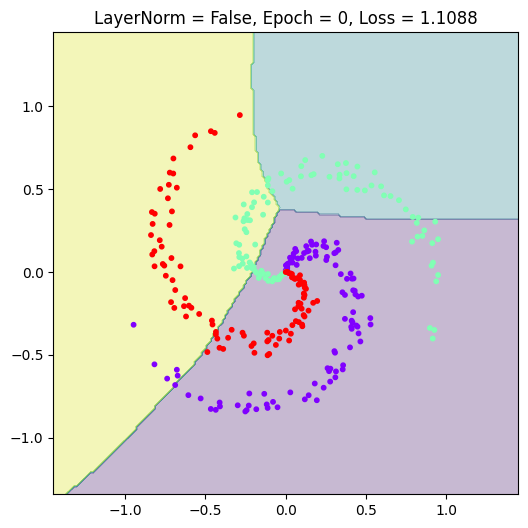

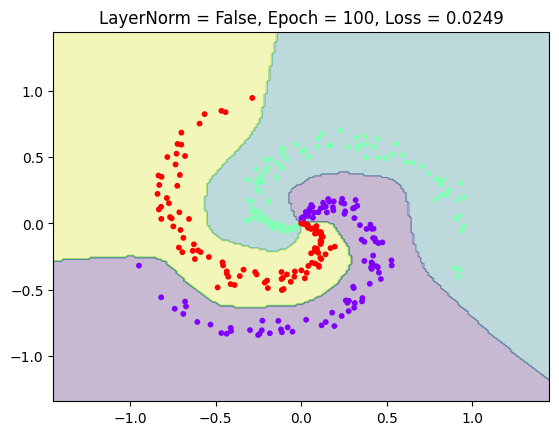

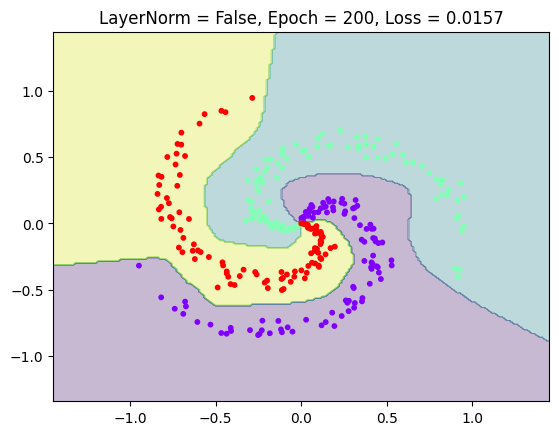

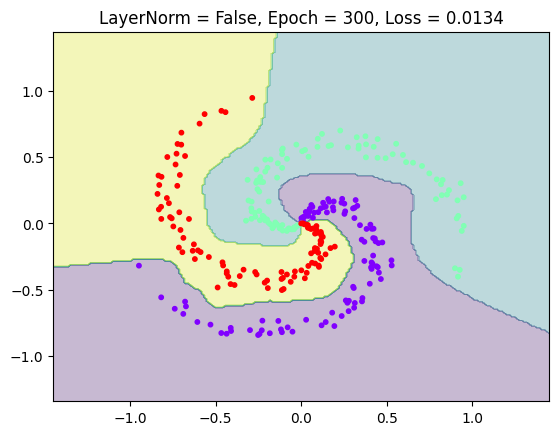

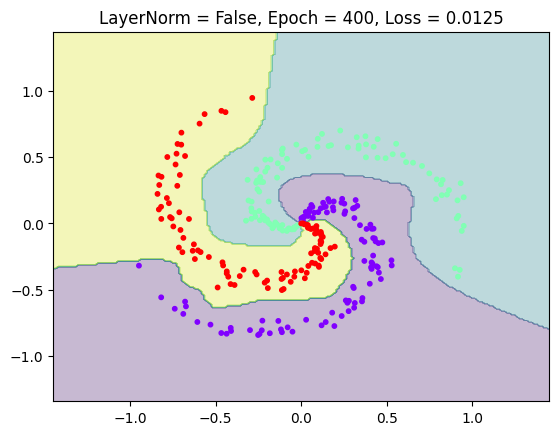

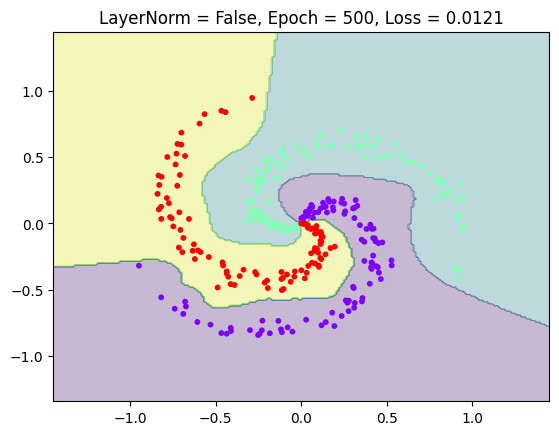

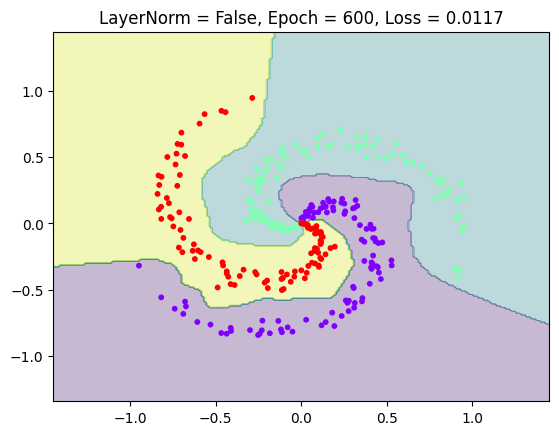

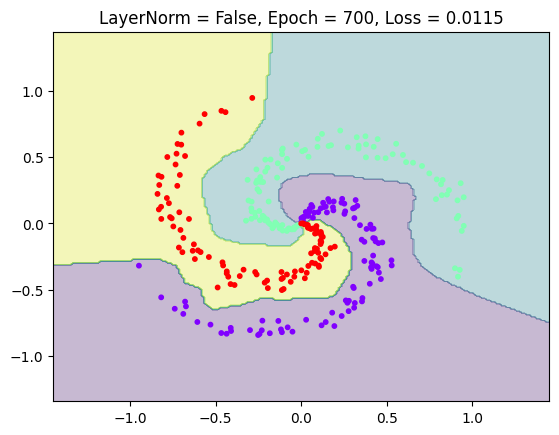

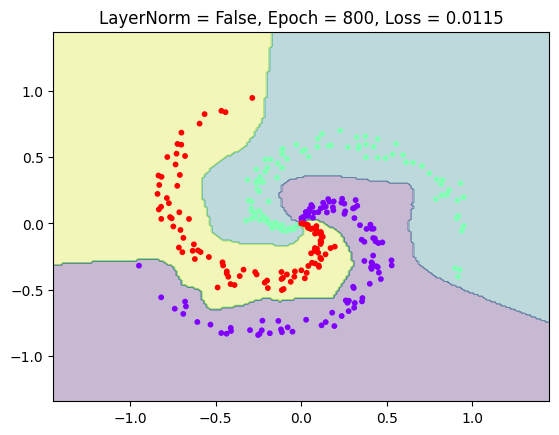

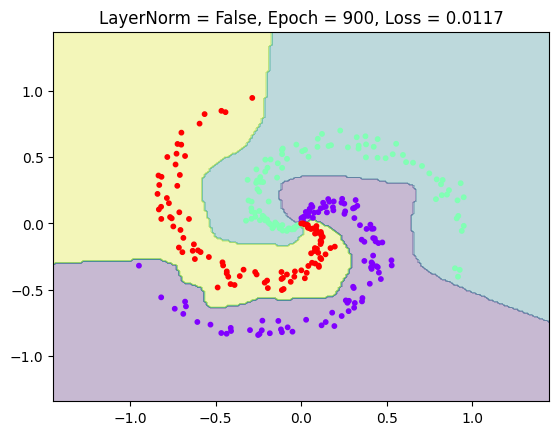

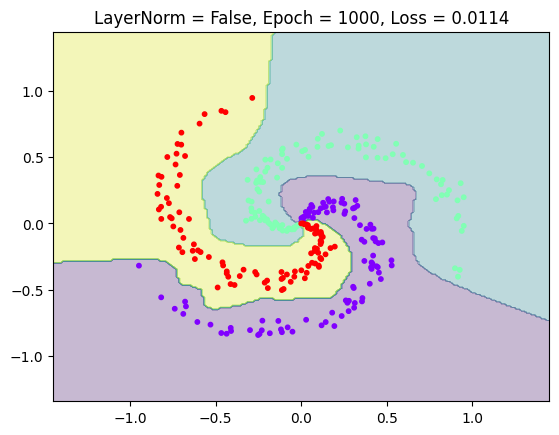

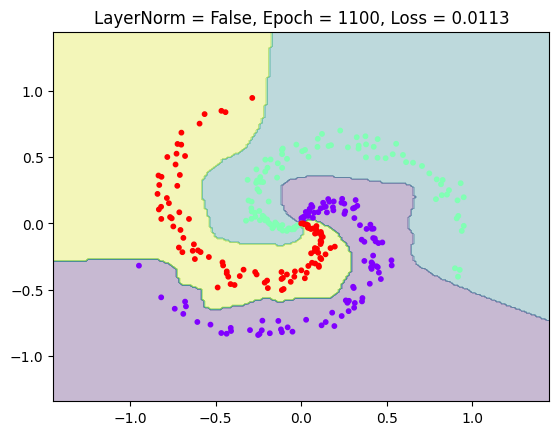

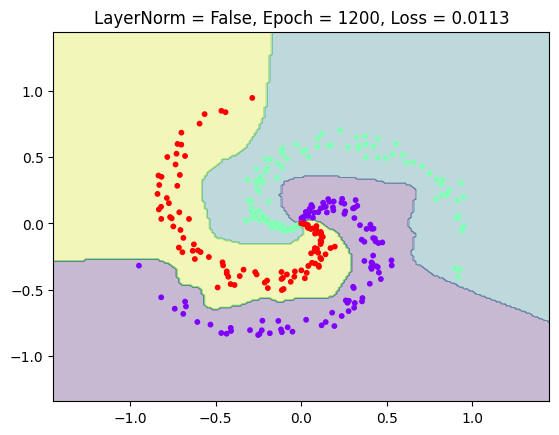

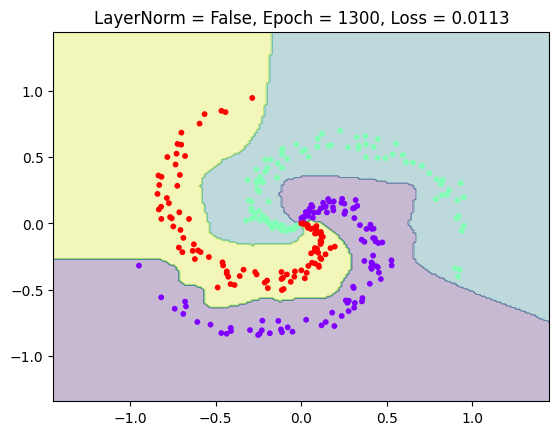

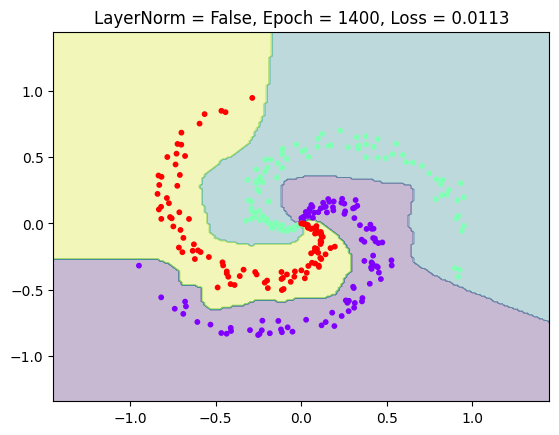

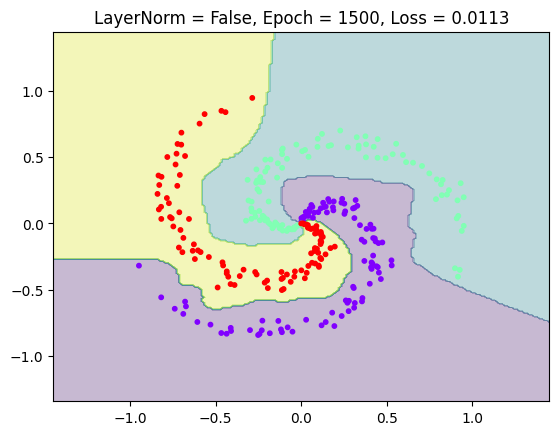

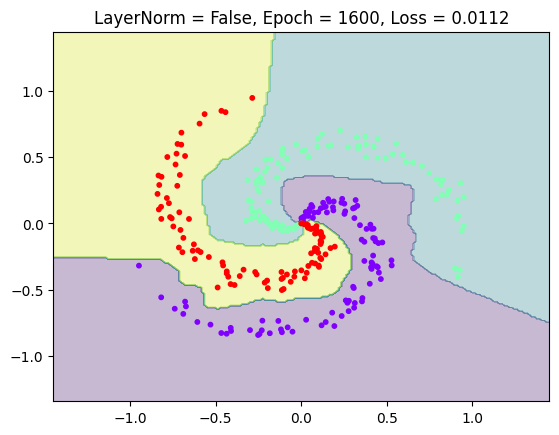

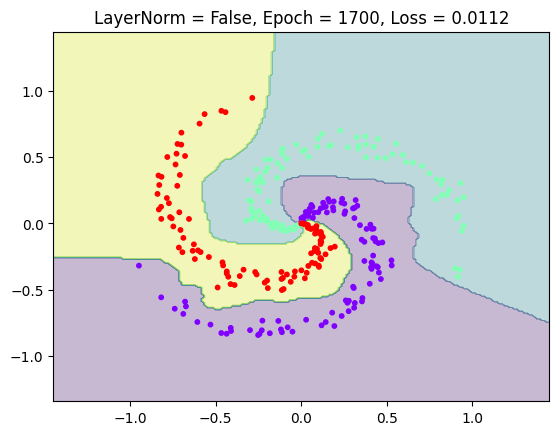

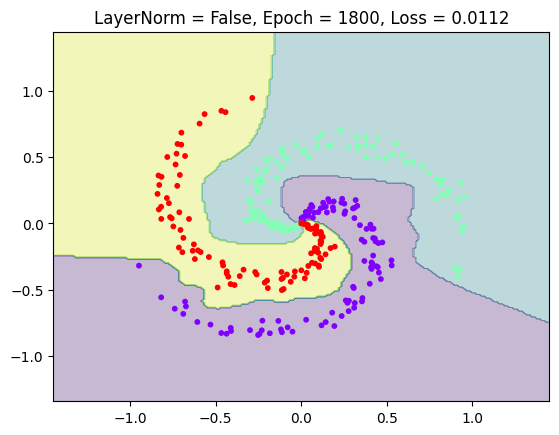

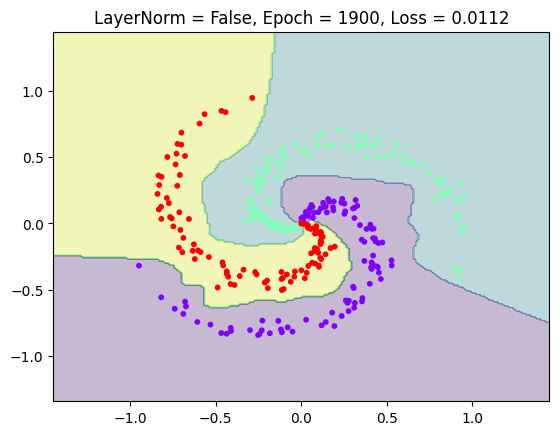

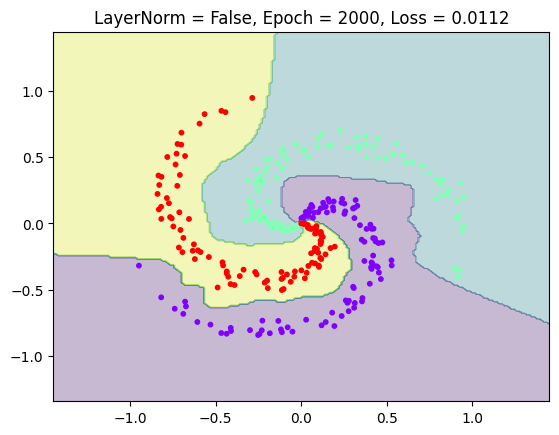

<Figure size 640x480 with 0 Axes>

Training WITH LayerNorm...


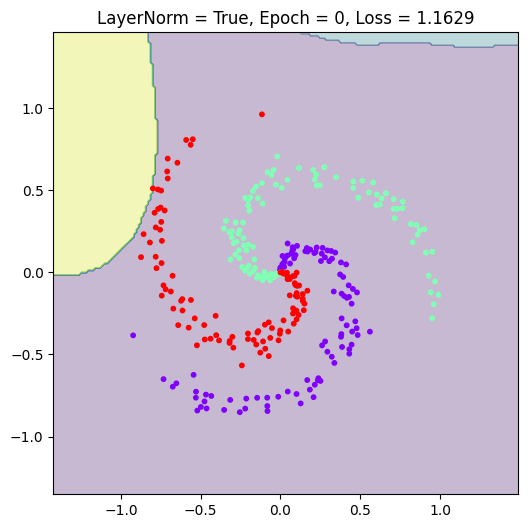

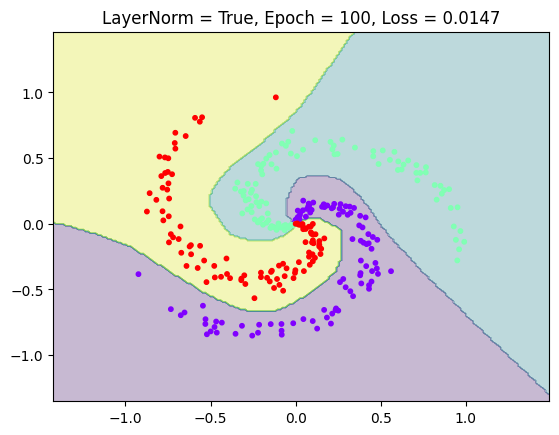

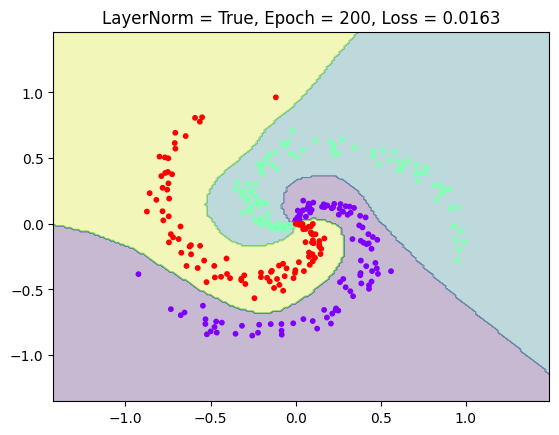

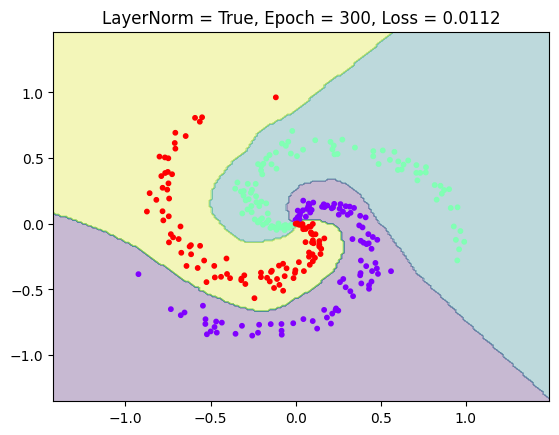

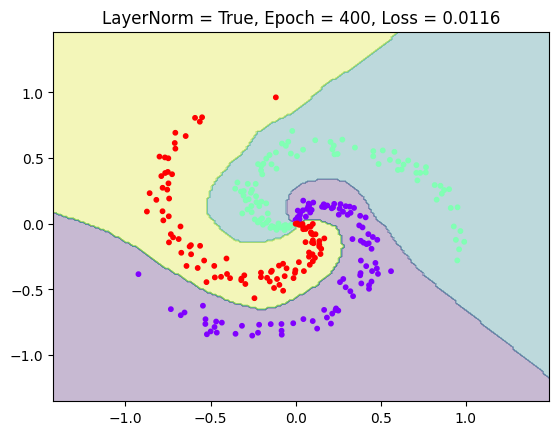

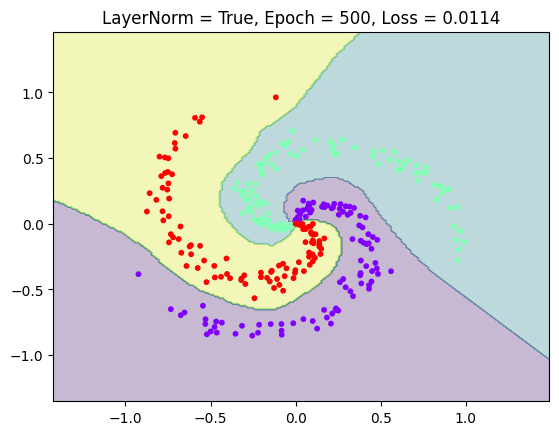

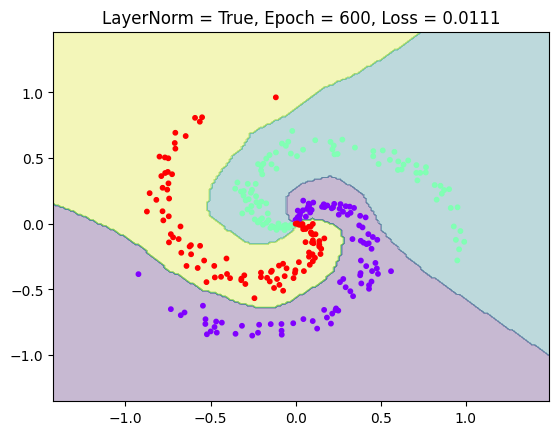

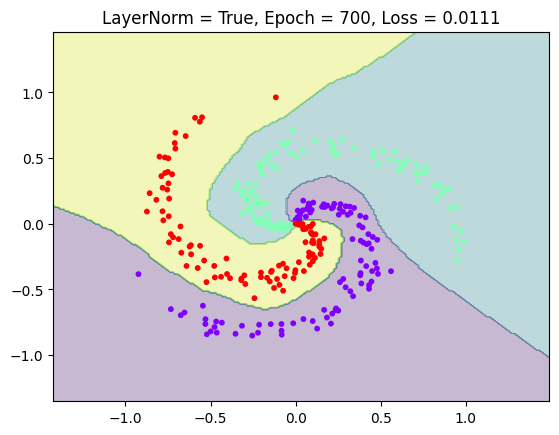

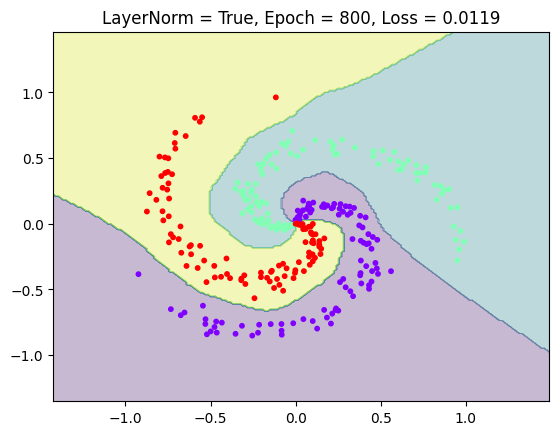

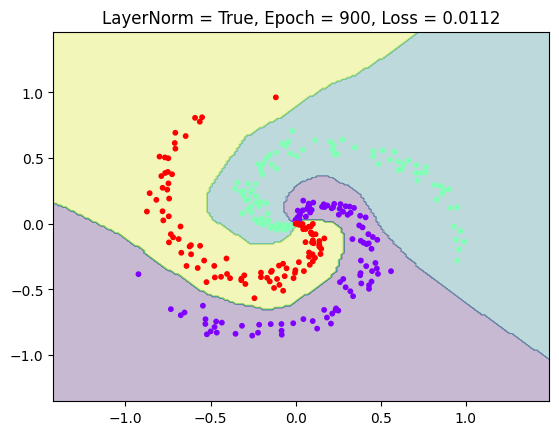

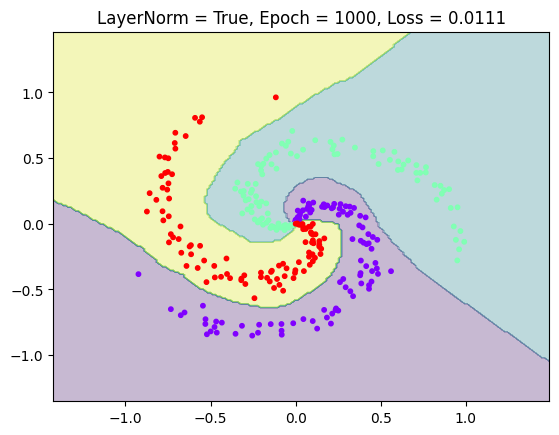

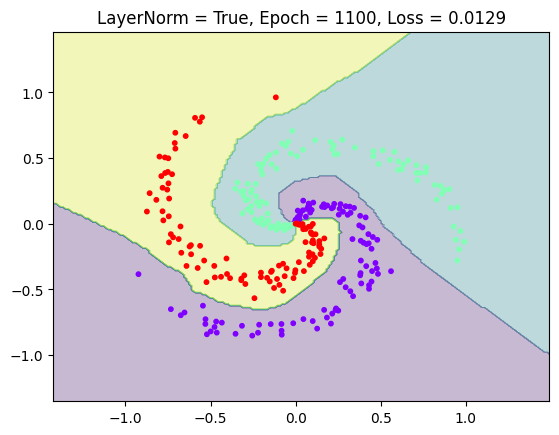

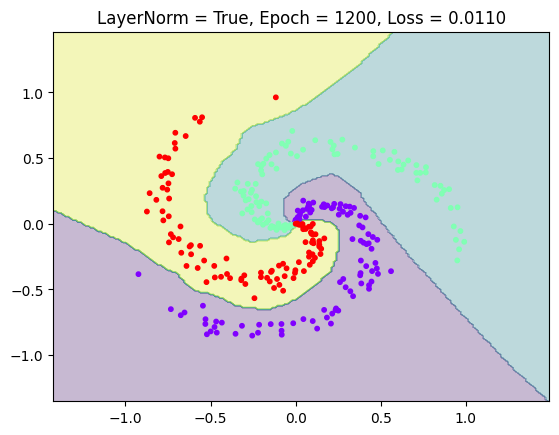

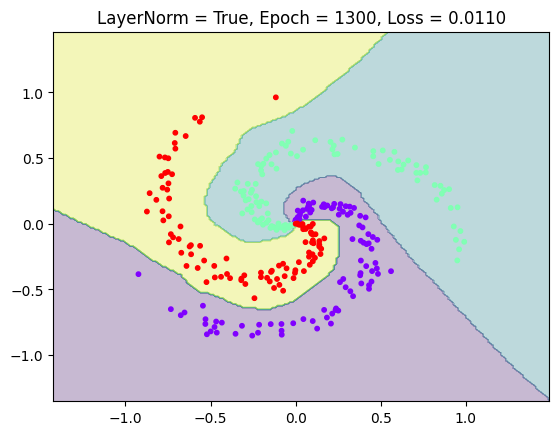

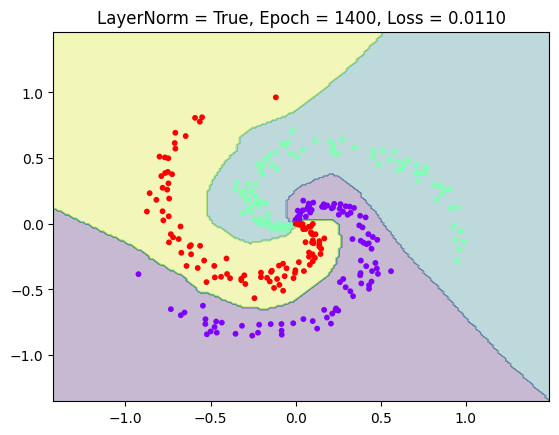

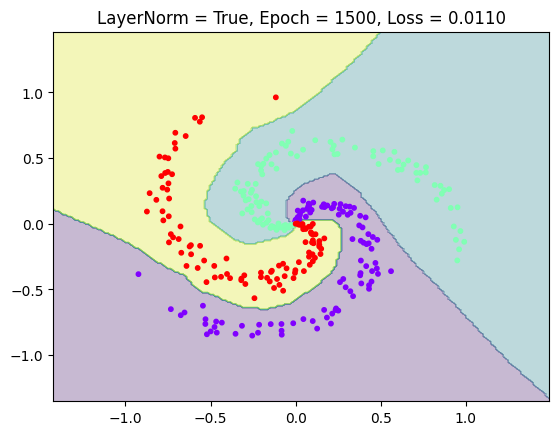

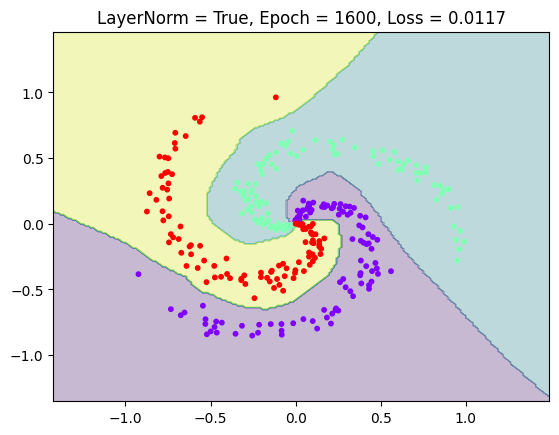

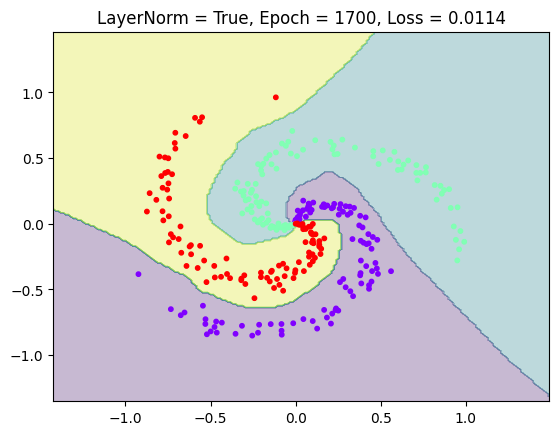

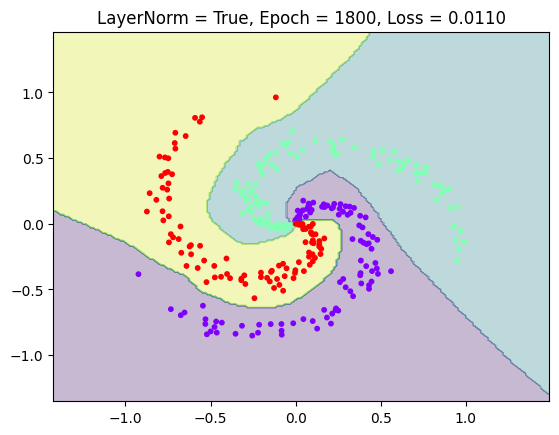

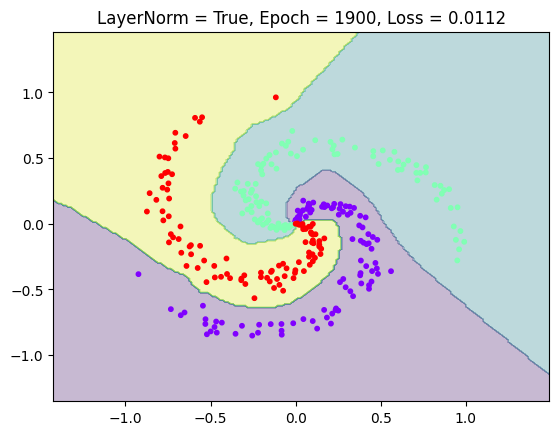

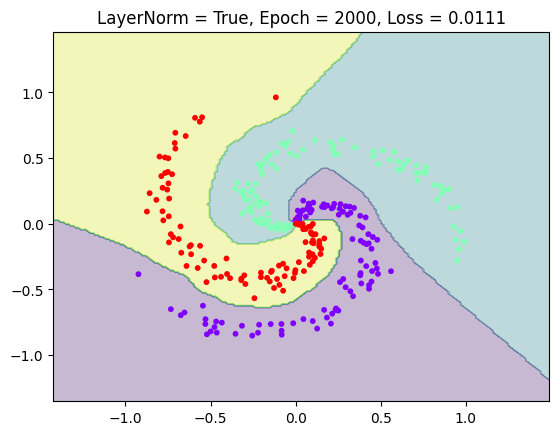

<Figure size 640x480 with 0 Axes>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


# ======== Spiral Dataset ========
def generate_spiral(n_points, n_classes):
    X = np.zeros((n_points * n_classes, 2))
    y = np.zeros(n_points * n_classes, dtype="uint8")

    for class_idx in range(n_classes):
        ix = range(n_points * class_idx, n_points * (class_idx + 1))
        r = np.linspace(0.0, 1, n_points)
        t = np.linspace(class_idx * 4, (class_idx + 1) * 4, n_points) + np.random.randn(n_points) * 0.2
        X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
        y[ix] = class_idx

    return torch.tensor(X, dtype=torch.float32), torch.tensor(y)


# ======== MLP Model Definition ========
class MLP(nn.Module):
    def __init__(self, use_ln=False):
        super().__init__()
        layers = []
        layers.append(nn.Linear(2, 128))
        if use_ln:
            layers.append(nn.LayerNorm(128))
        layers.append(nn.ReLU())

        layers.append(nn.Linear(128, 128))
        if use_ln:
            layers.append(nn.LayerNorm(128))
        layers.append(nn.ReLU())

        layers.append(nn.Linear(128, 3))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


# ======== Decision Boundary Plot ========
def plot_decision_boundary(model, X, y, title=""):
    model.eval()
    x_min, x_max = X[:,0].min()-0.5, X[:,0].max()+0.5
    y_min, y_max = X[:,1].min()-0.5, X[:,1].max()+0.5

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 200),
        np.linspace(y_min, y_max, 200)
    )
    grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
    with torch.no_grad():
        pred = model(grid).argmax(dim=1).reshape(xx.shape)

    plt.contourf(xx, yy, pred, alpha=0.3)
    plt.scatter(X[:,0], X[:,1], c=y, s=10, cmap="rainbow")
    plt.title(title)
    plt.pause(0.1)
    plt.clf()


# ======== Training Function ========
def train_and_visualize(use_ln=False):
    X, y = generate_spiral(100, 3)

    model = MLP(use_ln=use_ln)
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()

    plt.figure(figsize=(6,6))

    for epoch in range(2001):
        model.train()
        optimizer.zero_grad()
        pred = model(X)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()

        # Real-time visualization
        if epoch % 100 == 0:
            title = f"LayerNorm = {use_ln}, Epoch = {epoch}, Loss = {loss.item():.4f}"
            plot_decision_boundary(model, X, y, title)

    plt.show()


# ======== Run Experiments ========

print("Training WITHOUT LayerNorm...")
train_and_visualize(use_ln=False)

print("Training WITH LayerNorm...")
train_and_visualize(use_ln=True)

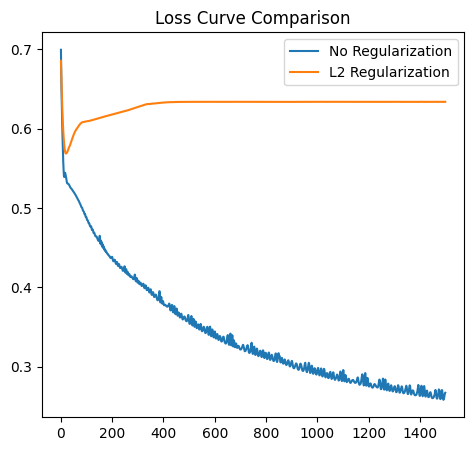

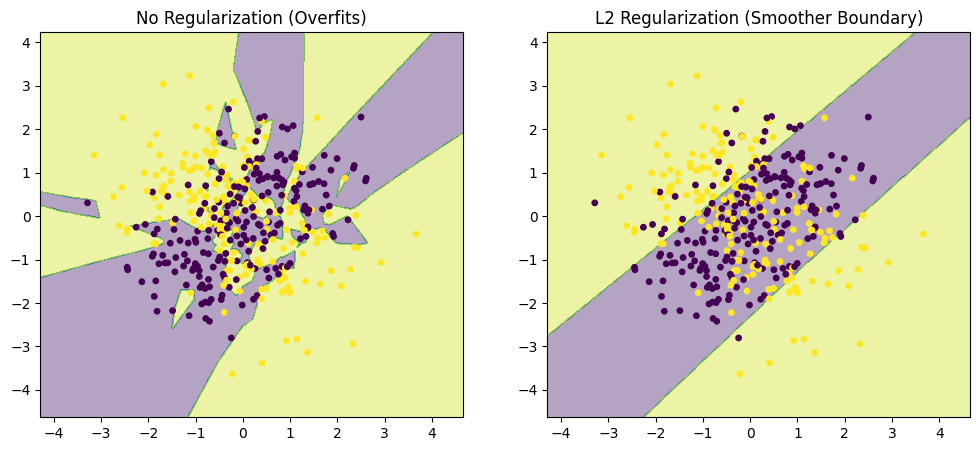

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# ================================
# 1. データセット（ノイズ大：過学習しやすい）
# ================================
np.random.seed(0)
N = 400

# XOR データ
x = np.random.randn(N, 2)
y = np.logical_xor(x[:, 0] > 0, x[:, 1] > 0).astype(int)

# ノイズ追加（正則化の効果が見えやすくなる）
x += np.random.randn(N, 2) * 0.6

x_tensor = torch.tensor(x, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)


# ================================
# 2. モデル定義
# ================================
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )
    def forward(self, x):
        return self.net(x)

# ================================
# 3. 正則化あり/なしモデルを作成
# ================================
model_plain = MLP()
model_l2 = MLP()

criterion = nn.CrossEntropyLoss()

optimizer_plain = optim.Adam(model_plain.parameters(), lr=0.01, weight_decay=0.0)
optimizer_l2    = optim.Adam(model_l2.parameters(),    lr=0.01, weight_decay=0.05)

EPOCHS = 1500
loss_plain_list = []
loss_l2_list = []


# ================================
# 4. 学習ループ
# ================================
for epoch in range(EPOCHS):

    # --- 正則化なし ---
    optimizer_plain.zero_grad()
    pred_plain = model_plain(x_tensor)
    loss_plain = criterion(pred_plain, y_tensor)
    loss_plain.backward()
    optimizer_plain.step()
    loss_plain_list.append(loss_plain.item())

    # --- L2 正則化あり ---
    optimizer_l2.zero_grad()
    pred_l2 = model_l2(x_tensor)
    loss_l2 = criterion(pred_l2, y_tensor)
    loss_l2.backward()
    optimizer_l2.step()
    loss_l2_list.append(loss_l2.item())


# ================================
# 5. 決定境界を描画する関数
# ================================
def plot_decision_boundary(model, title, subplot):
    h = 0.02
    xx, yy = np.meshgrid(
        np.arange(x[:, 0].min()-1, x[:, 0].max()+1, h),
        np.arange(x[:, 1].min()-1, x[:, 1].max()+1, h)
    )
    grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
    Z = model(grid)
    Z = Z.argmax(dim=1).numpy().reshape(xx.shape)

    plt.subplot(1, 2, subplot)
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(x[:, 0], x[:, 1], c=y, s=15)
    plt.title(title)


# ================================
# 6. 描画
# ================================
plt.figure(figsize=(12,5))

# --- ロスの推移 ---
plt.subplot(1,2,1)
plt.plot(loss_plain_list, label="No Regularization")
plt.plot(loss_l2_list, label="L2 Regularization")
plt.title("Loss Curve Comparison")
plt.legend()

# --- 決定境界 ---
plt.figure(figsize=(12,5))
plot_decision_boundary(model_plain, "No Regularization (Overfits)", 1)
plot_decision_boundary(model_l2, "L2 Regularization (Smoother Boundary)", 2)

plt.show()


Training WITHOUT LayerNorm...
Training WITH LayerNorm...


/tmp/ipython-input-3267114252.py:118: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()


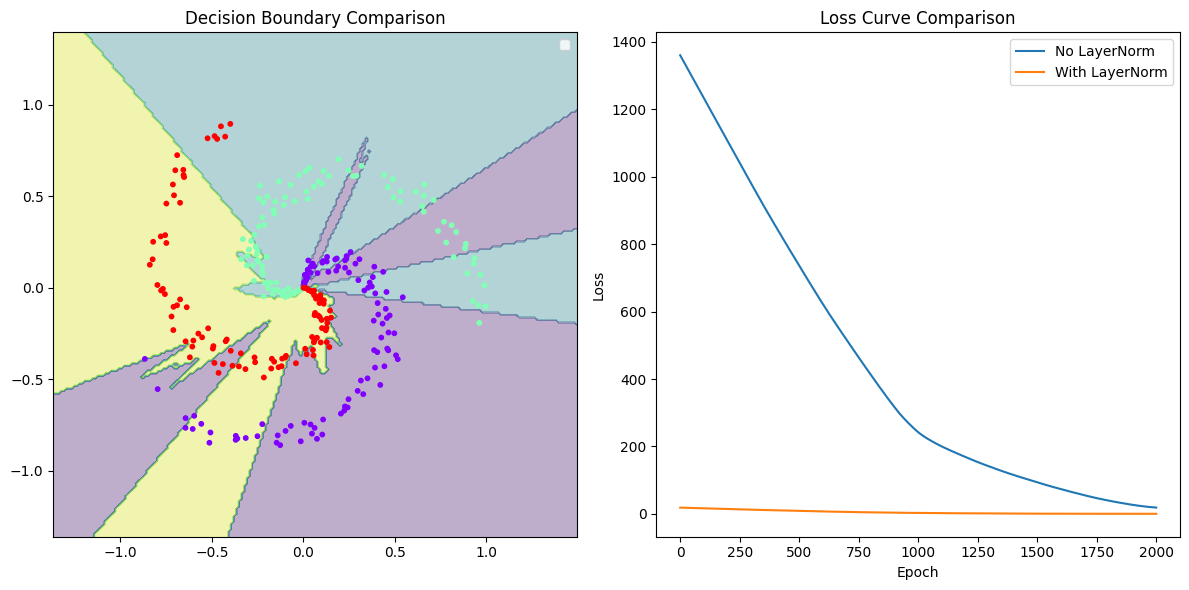

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


# ======== Spiral Dataset ========
def generate_spiral(n_points, n_classes):
    X = np.zeros((n_points * n_classes, 2))
    y = np.zeros(n_points * n_classes, dtype="uint8")

    for class_idx in range(n_classes):
        ix = range(n_points * class_idx, n_points * (class_idx + 1))
        r = np.linspace(0.0, 1, n_points)
        t = np.linspace(class_idx * 4, (class_idx + 1) * 4, n_points) + np.random.randn(n_points) * 0.2
        X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
        y[ix] = class_idx

    return torch.tensor(X, dtype=torch.float32), torch.tensor(y)


# ======== MLP Model Definition ========
class MLP(nn.Module):
    def __init__(self, use_ln=False):
        super().__init__()
        layers = []
        hidden = 256

        layers.append(nn.Linear(2, hidden))
        if use_ln: layers.append(nn.LayerNorm(hidden))
        layers.append(nn.ReLU())

        layers.append(nn.Linear(hidden, hidden))
        if use_ln: layers.append(nn.LayerNorm(hidden))
        layers.append(nn.ReLU())

        layers.append(nn.Linear(hidden, hidden))
        if use_ln: layers.append(nn.LayerNorm(hidden))
        layers.append(nn.ReLU())

        layers.append(nn.Linear(hidden, 3))
        self.net = nn.Sequential(*layers)

        # —— 重み初期化（難しくして差が出やすい設定） ——
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=1.0)  # 重め
                nn.init.zeros_(m.bias)

        self.use_ln = use_ln

    def forward(self, x):
        return self.net(x)


# ======== Decision Boundary Plot ========
def plot_decision_boundary(ax, model, X, y, title=""):
    model.eval()
    x_min, x_max = X[:,0].min()-0.5, X[:,0].max()+0.5
    y_min, y_max = X[:,1].min()-0.5, X[:,1].max()+0.5

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 200),
        np.linspace(y_min, y_max, 200)
    )
    grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
    with torch.no_grad():
        pred = model(grid).argmax(dim=1).reshape(xx.shape)

    ax.clear()
    ax.contourf(xx, yy, pred, alpha=0.35)
    ax.scatter(X[:,0], X[:,1], c=y, s=10, cmap="rainbow")
    ax.set_title(title)


# ======== Training Function (returns loss history) ========
def train_model(use_ln=False, epochs=2000):
    X, y = generate_spiral(100, 3)
    model = MLP(use_ln=use_ln)
    optimizer = optim.Adam(model.parameters(), lr=1e-5)
    criterion = nn.CrossEntropyLoss()

    loss_history = []
    model.train()

    for epoch in range(epochs):
        optimizer.zero_grad()
        pred = model(X)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()

        loss_history.append(loss.item())

    return model, X, y, loss_history


# ======== Combined Visualization ========
def train_and_visualize_both():
    epochs = 2000

    # 2モデルを学習
    print("Training WITHOUT LayerNorm...")
    model_no_ln, X, y, loss_no_ln = train_model(use_ln=False, epochs=epochs)

    print("Training WITH LayerNorm...")
    model_ln, _, _, loss_ln = train_model(use_ln=True, epochs=epochs)

    # ===== 可視化 =====
    plt.figure(figsize=(12, 6))

    # 左：決定境界比較
    ax1 = plt.subplot(1, 2, 1)
    plot_decision_boundary(ax1, model_no_ln, X, y, "Without LayerNorm")
    plot_decision_boundary(ax1, model_ln, X, y, "With LayerNorm")
    ax1.set_title("Decision Boundary Comparison")
    ax1.legend()

    # 右：ロス推移比較
    ax2 = plt.subplot(1, 2, 2)
    ax2.plot(loss_no_ln, label="No LayerNorm")
    ax2.plot(loss_ln, label="With LayerNorm")
    ax2.set_title("Loss Curve Comparison")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.legend()

    plt.tight_layout()
    plt.show()


# ======== Run ========
train_and_visualize_both()
